In [1]:
import tensorflow as tf
# 預設情況下，tensorflow會為了避免碎片化的記憶體造成效能不佳的情況而一次性的佔用顯卡所有記憶體，
# 這部份可以透過tf.config來限制硬體資源以及指定顯卡記憶體的使用。
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                # If memory growth is enabled for a PhysicalDevice, 
                # the runtime initialization will not allocate all memory on the device. 
                # Memory growth cannot be configured on a PhysicalDevice with virtual devices configured.
                tf.config.experimental.set_memory_growth(gpu, True)
            # 指定使用哪顆GPU
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)

In [2]:
select_gpu(2)
epochs = 10
model_name = 'bert-base'
sequence_length = 48
batch_size = 512

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [3]:
import pandas as pd
import numpy as np
import json

In [4]:
data_path = '/home/Danny/Data-Mining/lab2/kaggle/data/'

In [5]:
json_list = list()
with open(data_path + 'tweets_DM.json' , 'r') as file:
    for line in file:
        json_list.append(json.loads(line))

In [6]:
tweet_list = list()
for json in json_list:
    tweet_id = json['_source']['tweet']['tweet_id']
    hashtags = json['_source']['tweet']['hashtags']
    hashtag = ' '.join(hashtags)
    text = json['_source']['tweet']['text']
#     text = text + ' ' + hashtag
    tweet_list.append([tweet_id, text])

In [7]:
emotion_df = pd.read_csv(data_path + 'emotion.csv')
emotion_df

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [8]:
identification_df = pd.read_csv(data_path + 'data_identification.csv')
identification_df

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [9]:
emoji_dict = {
    "😂": "lolface",
    "😇": "smile",
    "😀": "smile",
    "🎉": "party",
    "😳": "embarrassed",
    "😔": "sadface",
    "👀": "shifty",
    "🤷": "shrugging",
    "💔": "brokenhearted",
    "👻": "ghost",
    "😍": "heart",
    "🙄": "disdain",
    "💖": "heart",
    "✌": "victory",
    "🎶": "music",
    "😱": "shock",
    "😃": "smile",
    "😒": "unsatisfied",
    "👊": "brofist",
    "😄": "smile",
    "🌞": "smile",
    "🙌": "celebration",
    "😁": "smile",
    "🤗": "hugging",
    "🤣": "rofl",
    "🌈": "gaypride",
    "😉": "winking",
    "💞": "heart",
    "🙃": "irony",
    "😜": "winking",
    "😭": "bawling",
    "🤔": "thinker",
    "😎": "cool",
    "💛": "heart",
    "💚": "heart",
    "💃": "fun",
    "💗": "heart",
    "😬": "awkward",
    "😌": "relieved",
    "😅": "whew",
    "💋": "kiss",
    "🙈": "laugh",
    "😊": "^^",
    "👌": "okay",
    "😡": "angry",
    "😘": "kiss",
    "😩": "weary",
    "🔥": "excellent",
    "💙": "heart",
    "💕": "heart",
    "👏": "clapping",
    "👍": "thumbsup",
    "💯": "perfect",
    "💜": "heart",
    "🕘" : "late",
    "😡" : "angry",
    "😒" : "dissatisfied",
    "😤" : "angry",
    "😠" : "angry",
    "😑" : "annoy",
    "😰": "anxious",
    "😯": "surprise",
    "😨": "scared",
    "😲": "astonished",
    "💪": "strong",
    "🤦": "facepalm",
    "✨": "sparkle",
    "😢": "crying",
    "💓": "heart",
    "👑": "crown",
    "🤘": "rockon",
    "🌹": "rose",
    "😋": "delicious",
    "😏": "flirting",
    "😆": "XD",
    "😫": "exhausted",
    "😦": "frowning",
    "🙏": "please",
}

In [10]:
frequent_name_dict = {
    "#realdonaldtrump": "sadness",
    "#fifthharmony": "sadness",
    "#mostrequestlive": "sadness",
    "#onairromeo": "sadness",
    "#matthardybrand": "sadness",
}

In [11]:
text_df = pd.DataFrame(tweet_list, columns=['tweet_id', 'text'])
text_df

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [12]:
# import re
# def replace_word(text):
#     text_list = text.split()
#     for i, j in enumerate(text_list):
#         if j in emoji_dict:
#             text_list[i] = emoji_dict[j]
#         if j in frequent_name_dict:
#             text_list[i] = frequent_name_dict[j]
#     text = ' '.join(text_list)
#     text = re.sub('<lh>|<|>|@|#|', '', text)
#     return text.split()

In [13]:
# text_df['token'] = text_df['text'].apply(lambda s : s.split())
# text_df

In [14]:
# %%time
# import nltk
# from nltk.tokenize import TweetTokenizer
# tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
# text_df['token'] = text_df['text'].apply(lambda s : s.lower())
# text_df['token'] = text_df['token'].apply(lambda s : tweet_tokenizer.tokenize(s))
# text_df['token'] = text_df['token'].apply(lambda s : ' '.join(s))
# text_df['token'] = text_df['token'].apply(lambda s : replace_word(s))
# text_df

In [15]:
%%time
from kashgari.tokenizers import BertTokenizer
vocab_path = '/home/Danny/pretrain_model/{}/vocab.txt'.format(model_name)
tokenizer = BertTokenizer.load_from_vocab_file(vocab_path)
text_df['token'] = text_df['text'].apply(lambda s : tokenizer.tokenize(s))
text_df

CPU times: user 6min 13s, sys: 2.84 s, total: 6min 16s
Wall time: 6min 17s


,tweet_id,text,token
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...","[people, who, post, "", add, me, on, #, snap, #..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[@, brian, ##kla, ##as, as, we, see, ,, trump,..."
2,0x28b412,"Confident of your obedience, I write to you, k...","[confident, of, your, obedience, ,, i, write, ..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,"[now, iss, ##a, is, stalking, tasha, 😂, ##😂, #..."
4,0x2de201,"""Trust is not the same as faith. A friend is s...","["", trust, is, not, the, same, as, faith, ., a..."
...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,"[when, you, buy, the, last, 2, tickets, remain..."
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,"[i, swear, all, this, hard, work, gone, pay, o..."
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,"[@, parcel, ##2, ##go, no, card, left, when, i..."
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...","[ah, ,, corporate, life, ,, where, you, can, d..."


In [16]:
test_df = identification_df[identification_df['identification'] == 'test']
# test_df

In [17]:
train_df = text_df.merge(emotion_df, left_on='tweet_id', right_on='tweet_id')
# train_df

In [18]:
x_list = train_df['token'].to_list()
y_list = train_df['emotion'].to_list()
print(len(x_list))
print(len(y_list))

1455563
1455563


In [19]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x_list, y_list, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))
print(len(valid_x), len(valid_y))

931560 931560
291113 291113
232890 232890


In [20]:
%%time
import kashgari
from kashgari.tasks.classification import BiLSTM_Model
kashgari.config.use_cudnn_cell = True
import logging
logging.basicConfig(level='DEBUG')
from kashgari.embeddings import BertEmbedding
bert_embed = BertEmbedding('/home/Danny/pretrain_model/{}'.format(model_name))
model = BiLSTM_Model(bert_embed, 
                     sequence_length=sequence_length,
#                      sequence_length: Union[str, int] = 'auto',
                    )
history = model.fit(train_x, 
                    train_y, 
                    valid_x, 
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
         )

2020-12-04 17:05:05,232 [DEBUG] kashgari - ------------------------------------------------
2020-12-04 17:05:05,233 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-04 17:05:05,233 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-base/bert_config.json
2020-12-04 17:05:05,234 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-base/vocab.txt
2020-12-04 17:05:05,234 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-base/bert_model.ckpt
2020-12-04 17:05:05,234 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]'

Epoch 1/10
1819/1819 [==============================] - 2955s 2s/step - loss: 1.2805 - accuracy: 0.5349 - val_loss: 1.1459 - val_accuracy: 0.5839
Epoch 2/10
1819/1819 [==============================] - 2732s 2s/step - loss: 1.1311 - accuracy: 0.5901 - val_loss: 1.1017 - val_accuracy: 0.5997
Epoch 3/10
1819/1819 [==============================] - 2441s 1s/step - loss: 1.0838 - accuracy: 0.6068 - val_loss: 1.0830 - val_accuracy: 0.6077
Epoch 4/10
1819/1819 [==============================] - 2540s 1s/step - loss: 1.0532 - accuracy: 0.6179 - val_loss: 1.0755 - val_accuracy: 0.6102
Epoch 5/10
1819/1819 [==============================] - 2406s 1s/step - loss: 1.0294 - accuracy: 0.6263 - val_loss: 1.0759 - val_accuracy: 0.6097
Epoch 6/10
1819/1819 [==============================] - 1590s 874ms/step - loss: 1.0104 - accuracy: 0.6333 - val_loss: 1.0746 - val_accuracy: 0.6104
Epoch 7/10
1819/1819 [==============================] - 1675s 921ms/step - loss: 0.9934 - accuracy: 0.6385 - val_loss: 1.

In [21]:
%%time
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)
model.evaluate(test_x, test_y)

2020-12-04 22:57:59,111 [INFO] kashgari - model saved to /home/Danny/Data-Mining/lab2/kaggle/kashgari/model/bert-base-epoch-10
2020-12-04 22:57:59,164 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 125
2020-12-04 22:58:02,100 [DEBUG] kashgari - predict input shape (2, 291113, 125) x: 
(array([[ 101, 2042, 1037, ...,    0,    0,    0],
       [ 101, 3582, 2256, ...,    0,    0,    0],
       [ 101, 4687, 2065, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2499, ...,    0,    0,    0],
       [ 101, 1026, 1048, ...,    0,    0,    0],
       [ 101, 6343, 3793, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2020-12-04 23:15:16,225 [DEBUG] kashgari - predict output shape (291113, 8)
2020-12-04 23:15:16,372 [DEBUG] kashgari - 

              precision    recall  f1-score   support

       anger     0.5424    0.2662    0.3571      7946
anticipation     0.6851    0.6026    0.6412     49984
     disgust     0.5009    0.4676    0.4837     27669
        fear     0.6956    0.4660    0.5581     12846
         joy     0.6345    0.8072    0.7105    102943
     sadness     0.5104    0.5820    0.5438     38745
    surprise     0.5913    0.2616    0.3627      9816
       trust     0.5802    0.4133    0.4827     41164

    accuracy                         0.6059    291113
   macro avg     0.5925    0.4833    0.5175    291113
weighted avg     0.6050    0.6059    0.5945    291113

CPU times: user 9min 58s, sys: 26 s, total: 10min 24s
Wall time: 17min 30s


{'detail': {'anger': {'precision': 0.5424467812259554,
   'recall': 0.26617165869619935,
   'f1-score': 0.35711270578303084,
   'support': 7946},
  'anticipation': {'precision': 0.6851215795100425,
   'recall': 0.6025928297055058,
   'f1-score': 0.6412125985928235,
   'support': 49984},
  'disgust': {'precision': 0.5008710464170958,
   'recall': 0.46759911814666233,
   'f1-score': 0.4836635514018692,
   'support': 27669},
  'fear': {'precision': 0.6955612363467348,
   'recall': 0.46598162852249725,
   'f1-score': 0.5580831624090994,
   'support': 12846},
  'joy': {'precision': 0.6344506375505841,
   'recall': 0.8071845584449647,
   'f1-score': 0.7104692770388991,
   'support': 102943},
  'sadness': {'precision': 0.5104008691912447,
   'recall': 0.5819847722286746,
   'f1-score': 0.5438473783223192,
   'support': 38745},
  'surprise': {'precision': 0.5912963389362192,
   'recall': 0.2616136919315403,
   'f1-score': 0.3627374814605551,
   'support': 9816},
  'trust': {'precision': 0.5801

DEBUG:matplotlib:CONFIGDIR=/home/Danny/.config/matplotlib
DEBUG:matplotlib:(private) matplotlib data path: /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:matplotlib data path: /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/Danny/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.2.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconf

DEBUG:matplotlib:CACHEDIR=/home/Danny/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/Danny/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gubbi' (Gubbi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-L.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:fin

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'aakar' (aakar-medium.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Thin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Uroob' (Uroob.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukti Narrow' (MuktiNarrowBold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Manjari' (Manjari-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sco

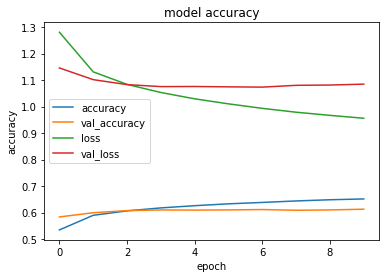

In [22]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [23]:
# model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
# model = kashgari.utils.load_model(model_path)
# model.evaluate(test_x, test_y)

In [24]:
test_df = test_df.merge(text_df, left_on='tweet_id', right_on='tweet_id')
# test_df

In [25]:
text_list = test_df['token'].tolist()
# text_list

In [26]:
%%time
predict_list = model.predict(text_list)
# predict_list

2020-12-04 23:15:27,510 [DEBUG] kashgari - predict input shape (2, 411972, 149) x: 
(array([[ 101, 1030, 5292, ...,    0,    0,    0],
       [ 101, 1030, 4419, ...,    0,    0,    0],
       [ 101, 2559, 2005, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2074, ...,    0,    0,    0],
       [ 101, 3713, 2069, ...,    0,    0,    0],
       [ 101, 2113, 2054, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2020-12-04 23:45:36,351 [DEBUG] kashgari - predict output shape (411972, 8)
2020-12-04 23:45:36,549 [DEBUG] kashgari - predict output argmax: [0 3 4 ... 3 0 0]


CPU times: user 17min 1s, sys: 46 s, total: 17min 47s
Wall time: 30min 13s


In [27]:
test_df['predict'] = predict_list
# test_df

In [28]:
output_df = test_df[['tweet_id', 'predict']]
output_df = output_df.rename(columns={'tweet_id':'id', 'predict':'emotion'})
# output_df

In [29]:
output_path = 'output/{}-epoch-{}.csv'.format(model_name, epochs)
output_df.to_csv(output_path, index=False, header=True)